# Parking Lot Problem

In this project we are going to predict the bounding boxes (object detection) of each occupied and empty space. We are going to use the YOLOv8 algorithm to do this.

This project has multiple applications:

- Parking lot monitoring
- Traffic monitoring
- Security monitoring
- ...

## Dataset

[The dataset](https://www.kaggle.com/datasets/blanderbuss/parking-lot-dataset) consists of multiple images from parking lots in different moments (cloudy, sunny, rainy).

The model shouldn't be affected by the weather conditions or location, so we will combine all the images and split them up in a 'train', 'test' and 'val' folder.

Since we are going to use YOLOv8, the labels also need to be in a specific format. We will use the script provided to convert the labels (xml) to the required format.

If you're running this project for yourself:

- Download the data from the provided link (see "Dataset" section)
- Place it in the same directory as this notebook in "/data"
- Make sure that the name of the zip folder is "archive.zip"
- Run the notebook

All the folders needed will be created automatically and the data will be processed and saved in the correct folders.

## Data Preprocessing

In [1]:
import zipfile

path_to_zip_file = "data/archive.zip"
directory_to_extract_to = "data/"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

### Merge all folders into one

In [2]:
import os
import shutil

source_folders = [
    "data/PKLot/PKLot/PKLot/PUCPR/Cloudy",
    "data/PKLot/PKLot/PKLot/PUCPR/Sunny",
    "data/PKLot/PKLot/PKLot/PUCPR/Rainy",
    "data/PKLot/PKLot/PKLot/UFPR04/Cloudy",
    "data/PKLot/PKLot/PKLot/UFPR04/Sunny",
    "data/PKLot/PKLot/PKLot/UFPR04/Rainy",
    "data/PKLot/PKLot/PKLot/UFPR05/Cloudy",
    "data/PKLot/PKLot/PKLot/UFPR05/Sunny",
    "data/PKLot/PKLot/PKLot/UFPR05/Rainy"
]

destination_folder = "data/total-content"

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Iterate through source folders and merge contents
for source_folder in source_folders:
    for root, _, files in os.walk(source_folder):
        for file in files:
            source_file_path = os.path.join(root, file)
            destination_file_path = os.path.join(destination_folder, file)
            shutil.copy(source_file_path, destination_file_path)

print("Contents merged successfully.")

Contents merged successfully.


### Modify labels

We also need to modify the labels to be in the same format as YOLOv8 requires. Our labels right now are in xml format, YOLOv8 need it in a txt file with the following format:
```
class x_center y_center width height
```

The next cell will convert the xml labels to txt labels and move the xml files since we don't need them.

The ``image_height`` and ``image_width`` need to be the height and the width of the image (as obvious as that sounds). This is because when converting from xml, we want to convert the bounding box coordinates to be relative to the image size. This is done by dividing the bounding box coordinates by the image size. This is also why we need to know the image size. (1280x720 in this case)

In [3]:
import xml.etree.ElementTree as ET

input_folder = "data/total-content"
output_folder = "data/labels-xml"

image_width = 1280
image_height = 720

class_mapping = {"1": 1, "0": 0}

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

xml_files = [f for f in os.listdir(input_folder) if f.endswith(".xml")]
for xml_file in xml_files:
    xml_path = os.path.join(input_folder, xml_file)
    
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    txt_filename = os.path.splitext(xml_file)[0] + ".txt"
    txt_path = os.path.join(output_folder, txt_filename)

    with open(txt_path, "w") as txt_file:
        for space in root.findall("space"):
            occupied = space.get("occupied")
            class_index = class_mapping.get(occupied, -1)
            
            if class_index == -1:
                continue
            
            rotated_rect = space.find("rotatedRect")
            center = rotated_rect.find("center")
            size = rotated_rect.find("size")
            
            center_x = float(center.get("x"))
            center_y = float(center.get("y"))
            width = float(size.get("w"))
            height = float(size.get("h"))
            
            x_center = center_x / image_width
            y_center = center_y / image_height
            w = width / image_width
            h = height / image_height
            
            txt_file.write(f"{class_index} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")
    
    new_xml_path = os.path.join(output_folder, xml_file)
    os.rename(xml_path, new_xml_path)

print("Annotations generated and XML files moved.")

Annotations generated and XML files moved.


In [4]:
# Move the txt files from the xml folder to the total-content folder

source_folder = "data/labels-xml"
destination_folder = "data/total-content"

txt_files = [f for f in os.listdir(source_folder) if f.endswith(".txt")]

for txt_file in txt_files:
    source_path = os.path.join(source_folder, txt_file)
    destination_path = os.path.join(destination_folder, txt_file)
    shutil.move(source_path, destination_path)

print("TXT files moved to data/total-content folder.")

TXT files moved to data/total-content folder.


### Train - Test - Val folders split

In [8]:
import random
import os

# remove the image that has no corresponding txt file

file_path = "data/total-content/2012-11-06_18_48_46.jpg"
try:
    os.remove(file_path)
    print(f"File '{file_path}' has been removed successfully.")
except OSError as e:
    print(f"Error removing the file '{file_path}': {e}")


source_folder = "data/total-content"
train_folder = "data/train"
test_folder = "data/test"
val_folder = "data/val"

train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

for folder in [train_folder, test_folder, val_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

all_files = os.listdir(source_folder)
image_files = [f for f in all_files if f.endswith(".jpg")]

# Calculate the number of samples for each split
num_samples = len(image_files)
num_train = int(train_ratio * num_samples)
num_test = int(test_ratio * num_samples)
num_val = num_samples - num_train - num_test

random.shuffle(image_files)

train_files = image_files[:num_train]
test_files = image_files[num_train:num_train + num_test]
val_files = image_files[num_train + num_test:]

# Move corresponding txt files along with images
for folder, files in [(train_folder, train_files), (test_folder, test_files), (val_folder, val_files)]:
    for file in files:
        # Move image file
        source_image_path = os.path.join(source_folder, file)
        destination_image_path = os.path.join(folder, file)
        shutil.move(source_image_path, destination_image_path)
        
        # Move corresponding txt file
        txt_file = os.path.splitext(file)[0] + ".txt"
        source_txt_path = os.path.join(source_folder, txt_file)
        destination_txt_path = os.path.join(folder, txt_file)
        shutil.move(source_txt_path, destination_txt_path)

print("Data split into train, test, and val sets.")

File 'data/total-content/2012-11-06_18_48_46.jpg' has been removed successfully.
Data split into train, test, and val sets.


In [9]:
# Organize the datasets into the following structure:
# data
# ├── train
# │   ├── images
# │   └── labels
# ├── val
# │   ├── images
# │   └── labels
# └── test
#     ├── images
#     └── labels


datasets = ['train', 'val', 'test']
source_folder = 'data'

for dataset in datasets:
	dataset_folder = os.path.join(source_folder, dataset)
	
	# Create "images" and "labels" folders
	images_folder = os.path.join(dataset_folder, "images")
	labels_folder = os.path.join(dataset_folder, "labels")
	os.makedirs(images_folder, exist_ok=True)
	os.makedirs(labels_folder, exist_ok=True)
	
	# Organize image and label files
	for file in os.listdir(dataset_folder):
		if file.endswith(".jpg"):
			image_path = os.path.join(dataset_folder, file)
			image_destination = os.path.join(images_folder, file)
			shutil.move(image_path, image_destination)
		elif file.endswith(".txt"):
			label_path = os.path.join(dataset_folder, file)
			label_destination = os.path.join(labels_folder, file)
			shutil.move(label_path, label_destination)

print("Datasets organized successfully.")

Datasets organized successfully.


## Model Loading, Fine Tuning and Evaluation

In [10]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:02<00:00, 9.60MB/s]


In [11]:
# Fine tuning

model.train(data="./data/data.yaml", epochs=2)

New https://pypi.org/project/ultralytics/8.0.150 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.149  Python-3.11.4 torch-2.0.1+cpu CPU (Intel Core(TM) i7-10750H 2.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=./data/data.yaml, epochs=2, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_

## Prediction on test set

In this section we will be using the fine-tuned model to predict the bounding boxes and classes of the images in the test set. A random image will be taken from the test set. The amount of bounding boxes will be shown first and then the image with the bounding boxes and classes. 

In [37]:
from PIL import Image

test_images_directory = "./data/test/images"

image_files = [f for f in os.listdir(test_images_directory) if f.lower().endswith(".jpg")]

random_image_filename = random.choice(image_files)
random_image_path = os.path.join(test_images_directory, random_image_filename)

results = model.predict(random_image_path)

result = results[0]

print(len(result.boxes))


image 1/1 c:\Users\denis\Desktop\projects\data-science\parking-lot-prediction\data\test\images\2013-03-21_18_15_14.jpg: 384x640 8 emptys, 33 occupieds, 201.0ms
Speed: 4.0ms preprocess, 201.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


41


In [38]:
for box in result.boxes:
	label = result.names[box.cls[0].item()]
	coords = [round(x) for x in box.xyxy[0].tolist()]
	prob = round(box.conf[0].item(), 4)
	print("Object: {}\nCoordinates: {}\nProbability: {}".format(label, coords, prob))

Object: occupied
Coordinates: [635, 14, 694, 66]
Probability: 0.9176
Object: occupied
Coordinates: [1089, 211, 1139, 309]
Probability: 0.9022
Object: empty
Coordinates: [674, 46, 739, 92]
Probability: 0.9004
Object: occupied
Coordinates: [510, 141, 553, 249]
Probability: 0.896
Object: occupied
Coordinates: [638, 506, 720, 682]
Probability: 0.8939
Object: empty
Coordinates: [471, 285, 533, 412]
Probability: 0.8938
Object: occupied
Coordinates: [578, 237, 636, 360]
Probability: 0.8904
Object: empty
Coordinates: [844, 45, 886, 140]
Probability: 0.8876
Object: occupied
Coordinates: [954, 117, 1002, 214]
Probability: 0.884
Object: occupied
Coordinates: [937, 229, 1012, 301]
Probability: 0.8794
Object: empty
Coordinates: [1162, 257, 1229, 375]
Probability: 0.8761
Object: occupied
Coordinates: [673, 373, 738, 499]
Probability: 0.8755
Object: occupied
Coordinates: [765, 109, 824, 162]
Probability: 0.8734
Object: occupied
Coordinates: [1001, 27, 1058, 85]
Probability: 0.8731
Object: occupied
Co

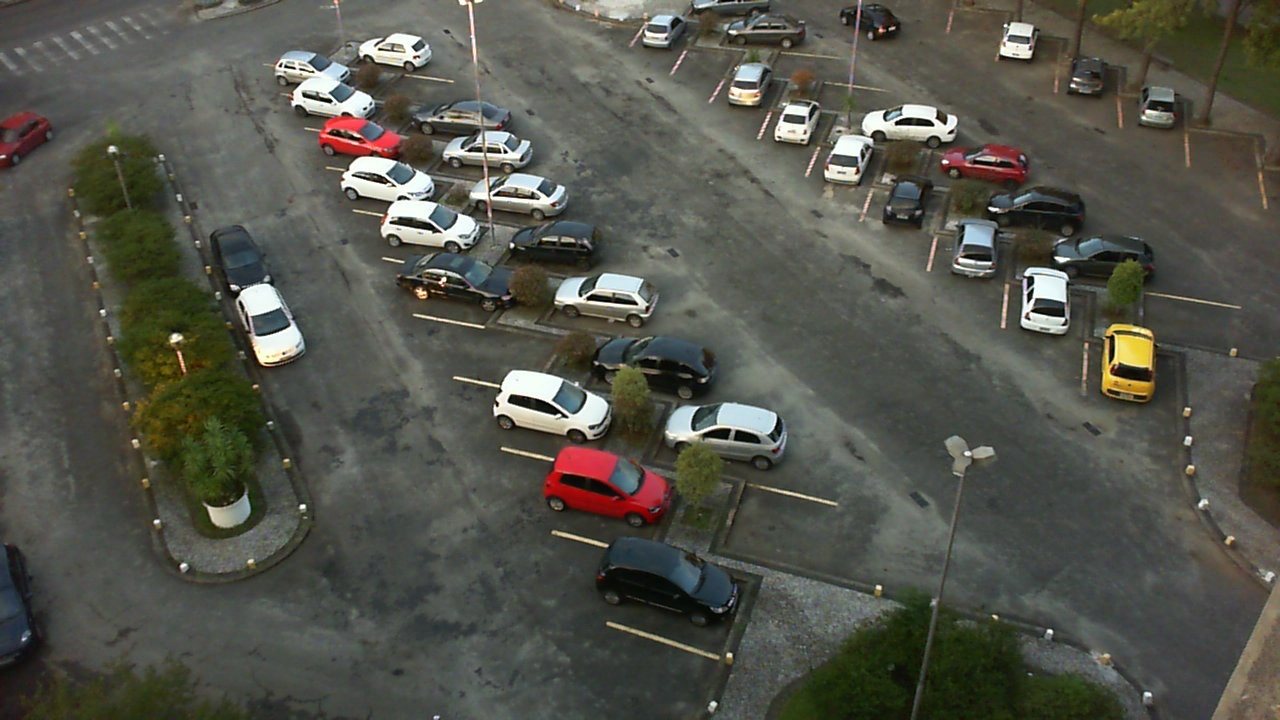

In [41]:
# Original image

Image.open(random_image_path)

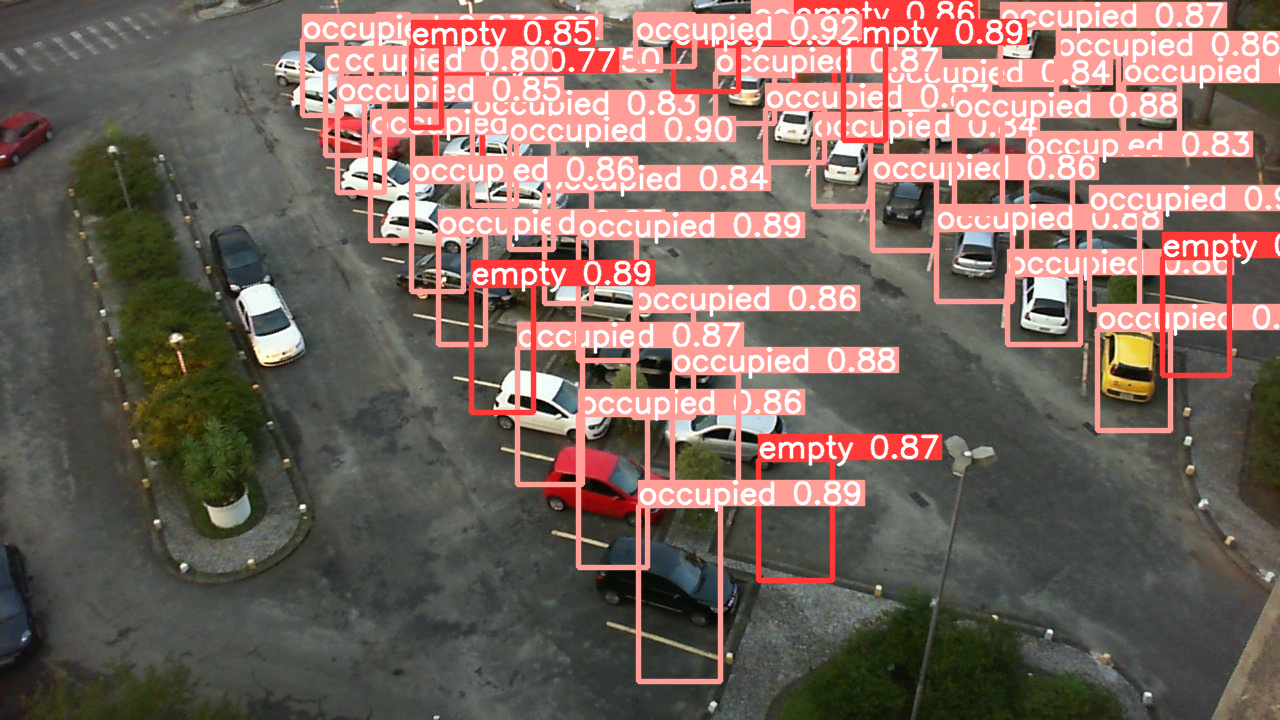

In [39]:
# Image with the result of the model

Image.fromarray(result.plot()[:,:,::-1])

To be able to upload this on github, the next section will deleting the data folder, but keeping some of the images in the test set. You don't have to do this. This is why I have placed the removal of the data in another notebook (remove_data.ipynb). You can also just delete the data folder, and keep some images of the test set, manually.